In [21]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
import joblib

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True

# Path config — edit if your layout is different
RESULTS_DIR = Path('../results')
METRICS_CSV = RESULTS_DIR / 'metrics_comparison.csv'
FEATURE_RF = RESULTS_DIR / 'feature_importance_rf.csv'
FEATURE_XGB = RESULTS_DIR / 'feature_importance_xgb.csv'

def load_matrix(path: Path):
    """Robust loader for matrices saved by preprocessing.
    Tries .npz (sparse), then .npy (dense). If called without suffix, attempts both.
    """
    path = Path(path)
    candidates = []
    if path.suffix:
        candidates.append(path)
    candidates.extend([path.with_suffix('.npz'), path.with_suffix('.npy')])

    for p in candidates:
        if not p.exists():
            continue
        try:
            return sparse.load_npz(p)
        except Exception:
            try:
                return np.load(p, allow_pickle=False)
            except Exception:
                pass
    raise FileNotFoundError(f'Could not load matrix for {path} (tried .npz and .npy).')


In [22]:
# Load the metrics table produced by train_models.py
# Expected columns: ['Model', 'Split', 'R2_log', 'MAE_raw', 'RMSE_raw']
metrics = pd.read_csv(METRICS_CSV)
display(metrics)

# Validate required columns
required_cols = {'Model', 'Split', 'R2_log', 'MAE_raw', 'RMSE_raw'}
missing = required_cols - set(metrics.columns)
if missing:
    raise ValueError(f"metrics_comparison.csv is missing columns: {missing}")


,Model,Split,R2_log,MAE_raw,RMSE_raw
0,LinearRegression,valid,0.915959,13048.957460,24028.848600
1,LinearRegression,test,0.868778,14067.980157,29038.655822
2,RandomForest,valid,0.890540,15065.774933,25088.529262
3,RandomForest,test,0.848380,16211.735337,26865.945959
4,XGBoost,valid,0.923154,12909.683292,19693.338460
5,XGBoost,test,0.894759,13813.197630,21658.140865


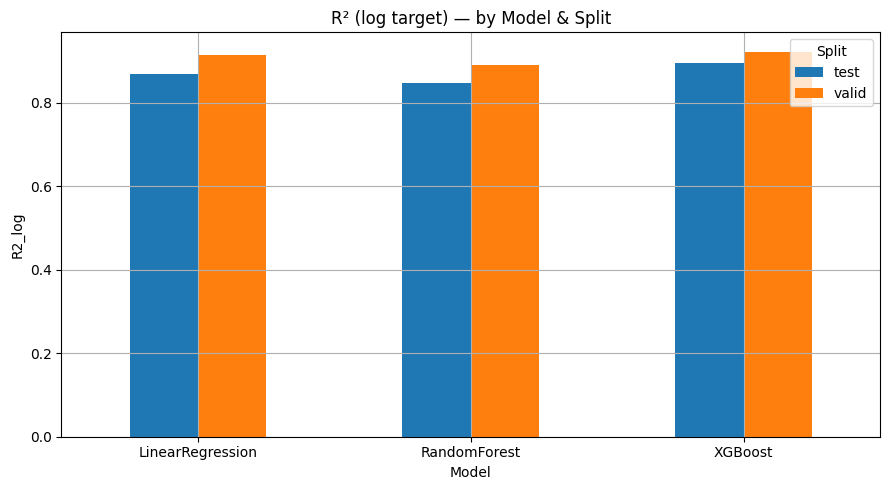

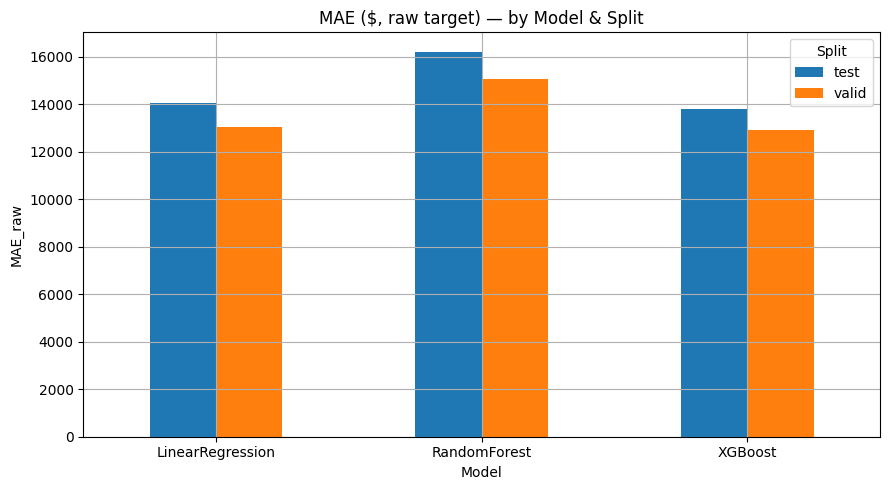

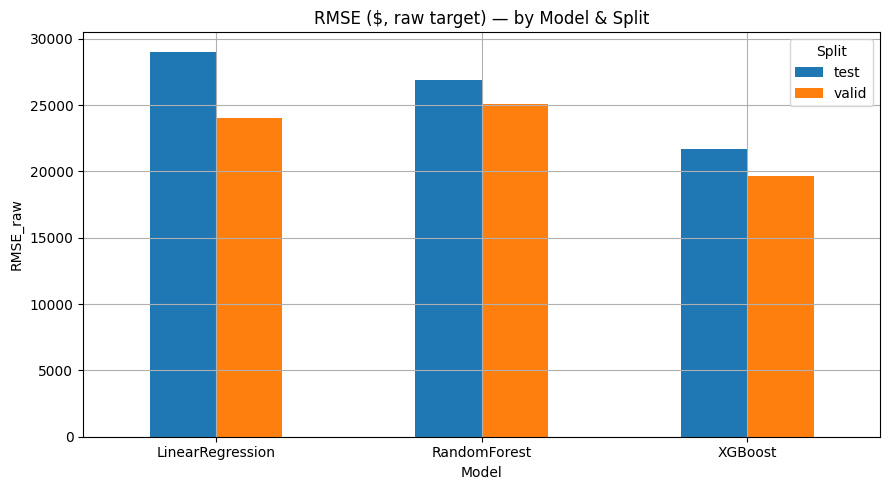

In [23]:
# Bar Charts - Validation and Test metrics
def plot_metric(df: pd.DataFrame, metric: str, title: str):
    """Plot a bar chart of metric values for each Model x Split."""
    pivot = df.pivot(index='Model', columns='Split', values=metric)
    ax = pivot.plot(kind='bar', rot=0, figsize=(9,5), title=title)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    plt.tight_layout()
    plt.show()

# R² on log target
plot_metric(metrics, 'R2_log', 'R² (log target) — by Model & Split')
# MAE and RMSE on raw $ target
plot_metric(metrics, 'MAE_raw', 'MAE ($, raw target) — by Model & Split')
plot_metric(metrics, 'RMSE_raw', 'RMSE ($, raw target) — by Model & Split')


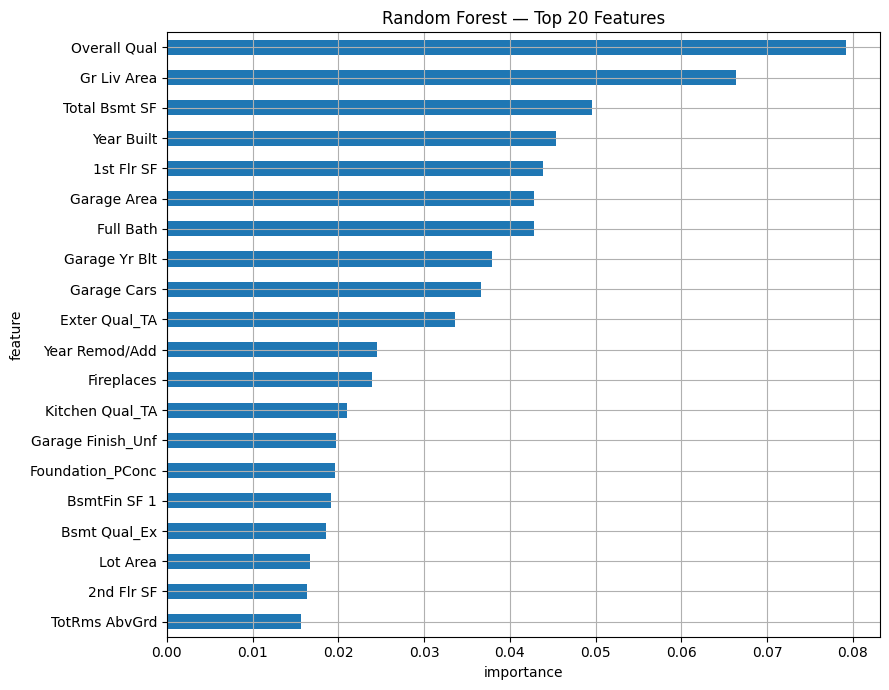

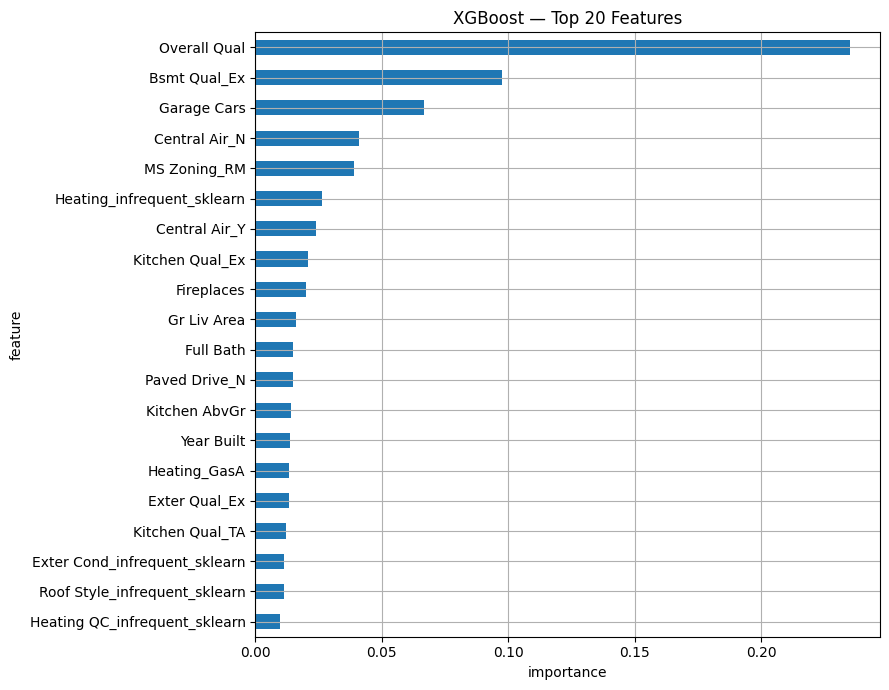

In [24]:
# Feature importances (random forest and XGBoost)
def plot_top_importances(path_csv: Path, title: str, top_n: int = 20):
    """Read feature importances CSV and plot top-N bars. Skip if file missing."""
    if not path_csv.exists():
        print(f'[skip] {title}: {path_csv.name} not found; ensure the corresponding model was trained.')
        return
    imp = pd.read_csv(path_csv)
    if not {'feature', 'importance'}.issubset(imp.columns):
        print(f'[skip] {title}: CSV missing expected columns.')
        return
    imp = imp.sort_values('importance', ascending=False).head(top_n)
    ax = imp.iloc[::-1].plot(kind='barh', x='feature', y='importance', legend=False, figsize=(9,7), title=title)
    ax.set_xlabel('importance')
    ax.set_ylabel('feature')
    plt.tight_layout()
    plt.show()

plot_top_importances(FEATURE_RF, 'Random Forest — Top 20 Features')
plot_top_importances(FEATURE_XGB, 'XGBoost — Top 20 Features')


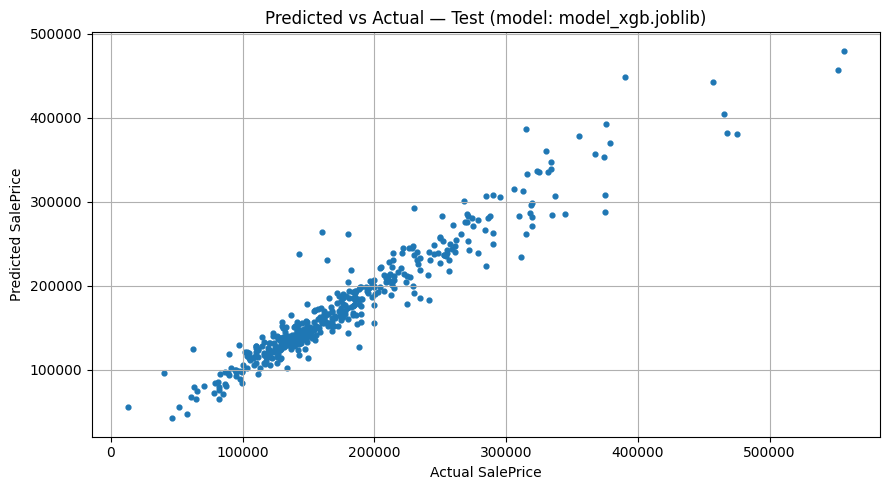

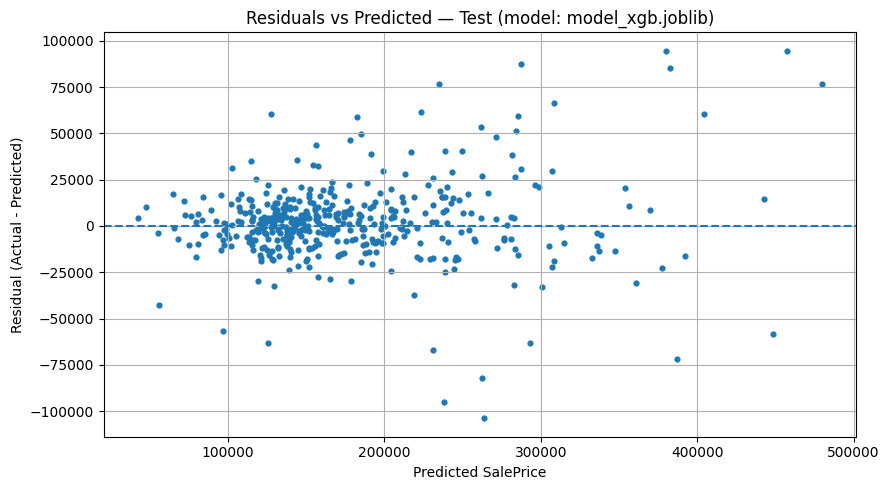

,Residuals Summary
count,440.000000
mean,2094.876802
std,21581.127599
min,-103863.625000
25%,-7731.279297
50%,1422.578125
75%,9742.804688
max,94650.562500


In [25]:
# Residual analysis on test set

# Load test matrices and targets
X_test = load_matrix(RESULTS_DIR / 'X_test')
y_test_log = np.load(RESULTS_DIR / 'y_test_log.npy')
y_test_raw = np.load(RESULTS_DIR / 'y_test_raw.npy')

# Choose best available model (prefer tuned)
model_paths_ordered = [
    RESULTS_DIR / 'model_xgb_tuned.joblib',
    RESULTS_DIR / 'model_xgb.joblib',
    RESULTS_DIR / 'model_rf_tuned.joblib',
    RESULTS_DIR / 'model_rf.joblib',
    RESULTS_DIR / 'model_linear.joblib',
]
model = None
chosen = None
for p in model_paths_ordered:
    if p.exists():
        model = joblib.load(p)
        chosen = p.name
        break
if model is None:
    raise FileNotFoundError('No trained model found in results/. Run train_models.py first.')

from sklearn.ensemble import RandomForestRegressor
def to_dense_if_needed(X, model_obj):
    # RandomForest requires dense inputs; others can use sparse.
    if isinstance(model_obj, RandomForestRegressor) and sparse.issparse(X):
        return X.toarray()
    return X

# Predict and invert log-transform
y_pred_log = model.predict(to_dense_if_needed(X_test, model))
y_pred_raw = np.expm1(y_pred_log)

# Scatter: predicted vs actual
plt.figure()
plt.scatter(y_test_raw, y_pred_raw, s=12)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title(f'Predicted vs Actual — Test (model: {chosen})')
plt.tight_layout()
plt.show()

# Residuals vs Predicted
residuals = y_test_raw - y_pred_raw
plt.figure()
plt.scatter(y_pred_raw, residuals, s=12)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residual (Actual - Predicted)')
plt.title(f'Residuals vs Predicted — Test (model: {chosen})')
plt.tight_layout()
plt.show()

# Residual summary stats — useful for the write-up
pd.Series(residuals).describe().to_frame('Residuals Summary')
